# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def NGD2L_TK(T, alpha, beta, gamma, g, h, l, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta*z[j]  + g*y[j] )
        dw=dt*(-gamma*w[j] + h*y[j]-l*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw

    nTK = w[::10]/(dt) #normalized by integration
    return -Amp*nTK

In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

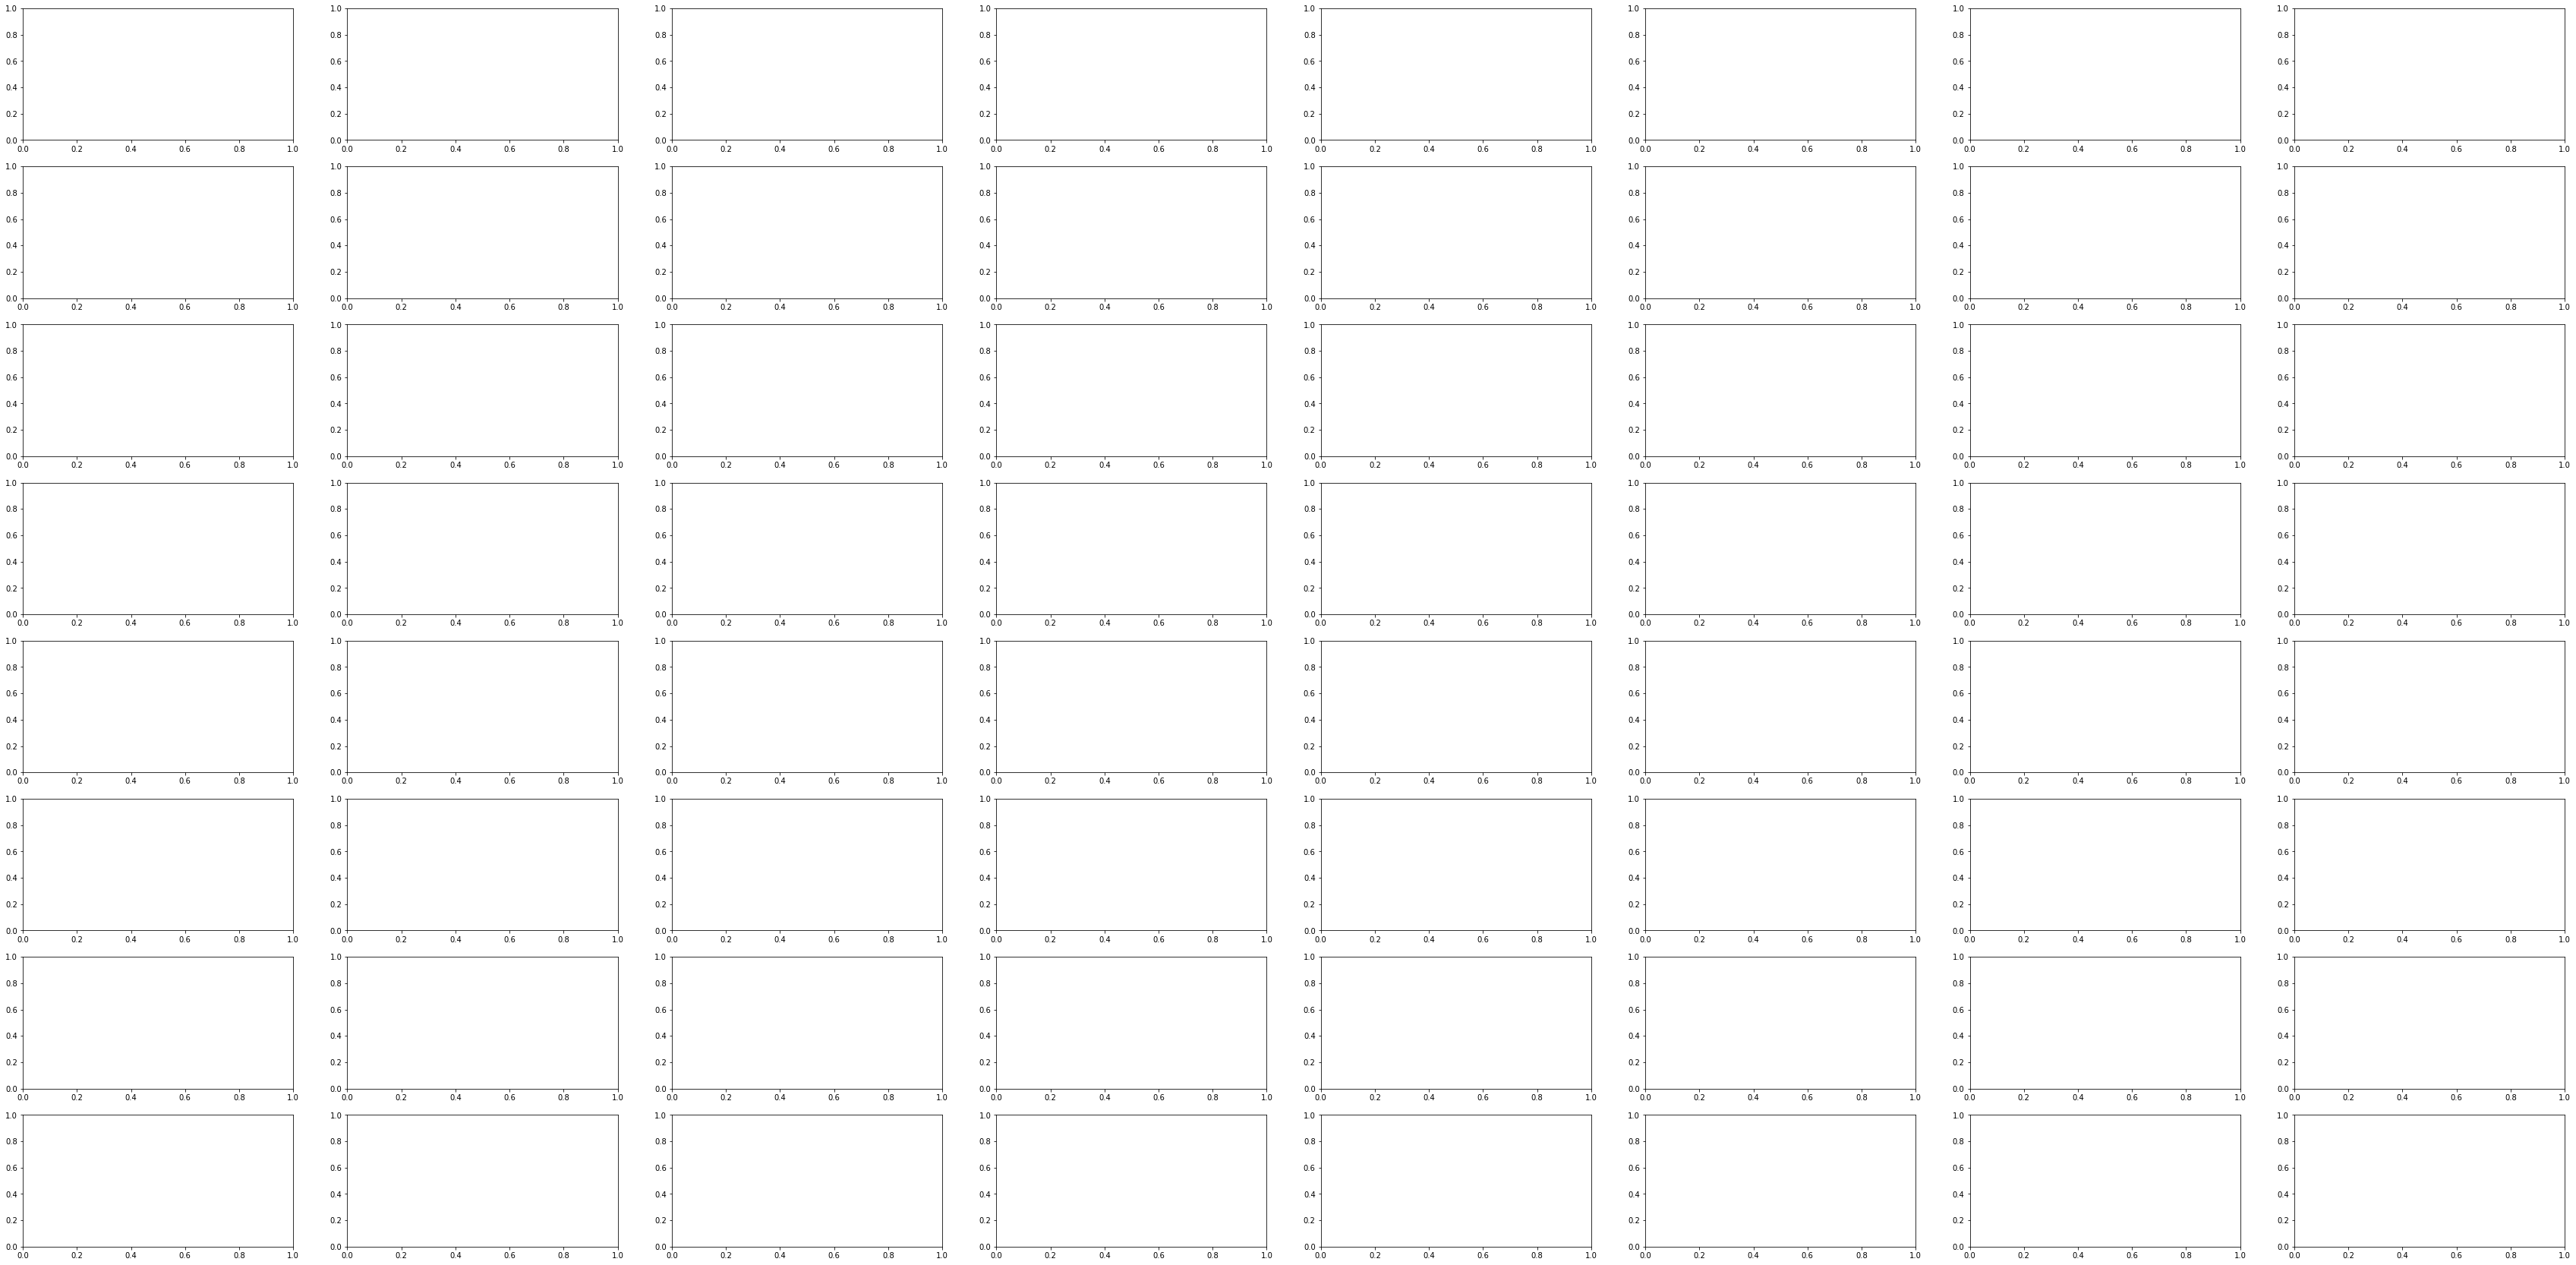

In [4]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)
fig, ax = plt.subplots(nrows=8, ncols=8)
fig.set_size_inches(60, 30)

# main

In [5]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210504'
annots = loadmat(exp_folder+'\\merge\\merge_0224_cSTA_wf_3min_Q100_re', squeeze_me = True)
x = annots['bin_pos']
x = x-np.mean(x)
dt = 1/60
cSTA_list = [0]*60
dcn = []
for cn in range(60):
    spike = annots['reconstruct_spikes'][cn]
#     if type(spike) == float: continue
#     elif len(spike)/((len(x)+1)*dt) < 0.3: continue
    rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)
    
    cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
    taxis = -np.arange(len(cSTA))*dt
    if (np.abs(cSTA[:round(len(cSTA)/2)]) < 7*np.std(cSTA[round(len(cSTA)/2):-1])).all(): continue
    if sum(cSTA[:8]) < -1: dcn.append(cn) # exclude fitting of On-cell from fitting
    ax[np.where(figmap == cn+1)][0].plot(taxis, cSTA, 'b+:')
    cSTA_list[cn] = cSTA

In [ ]:
name_list = ['alpha', 'beta', 'gamma', 'g', 'h', 'l', 'tau_y', 'Amp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)

fit_cSTA_list = [0]*60
para_dict['error'] = np.zeros(60)
for cn in dcn.copy():
#     print(cn)
    alpha = 33. #1/sec
    beta =  2
    gamma = 46
    g = 680
    h = 14
    i = 0.3
    tau_y = 0.02
    try:
        popt,pcov = curve_fit(NGD2L_TK, np.abs(taxis), cSTA_list[cn], p0=[alpha, beta, gamma, g, h, l, tau_y, 1],
                              bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.1, np.inf]))
    except:
        dcn.remove(cn)
        continue
    for l in range(len(popt)):
        para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
    fit_cSTA_list[cn] = NGD2L_TK(np.abs(taxis), *popt).copy()
    para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
    ax[np.where(figmap == cn+1)][0].plot(taxis, fit_cSTA_list[cn], 'r-')

In [ ]:
for cn in range(60):
    ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
fig.set_size_inches(30, 15)
fig.tight_layout()
fig

In [ ]:
fig.set_size_inches(50, 25)
fig.tight_layout()
fig.savefig(exp_folder+'\\FIG\\cSTA\\fitNGD2Lparameter.tiff', bbox_inches = 'tight',pad_inches = 0.3)

In [ ]:
np.save(exp_folder+'\\Analyzed_data\\fitNGD2Lpara', para_dict)

# examine date


## exclude on cell

In [ ]:
Dfig, Dax = plt.subplots(nrows=8, ncols=8)
Dfig.set_size_inches(30, 15)
Dfig.tight_layout()
pcn = []
ncn = []
for cn in dcn:
    #constrani 1
    if len(annots['reconstruct_spikes'][cn])/180 < 0.3: continue
    domega = 0.01
    omega = np.arange(-1,10,domega) #limited by [pi/dt,pi/dt)
    TKdw = np.sum(fit_cSTA_list[cn][np.newaxis,:]*np.exp(-1j*np.abs(taxis[np.newaxis,:])*omega[:,np.newaxis]), axis = 1)*dt
    phi = np.angle(TKdw)
    delta = -angular_gradient(phi)/domega
    Dax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
        
    #constrani 2
    if delta[0] < 0: 
        pcn.append(cn)
        Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'g')
    else: 
        ncn.append(cn)
        Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'm')
        
for Daxy in Dax:
    for ax in Daxy:
        ax.axhline(0,linewidth=1, linestyle='--', c='k')
        ax.set_xlim([0,10])

In [ ]:
Dfig.set_size_inches(50, 25)
Dfig.tight_layout()
Dfig.savefig(exp_folder+'\\FIG\\cSTA\\GroupDelay.tiff', bbox_inches = 'tight',pad_inches = 0.3)

In [ ]:
data = para_dict['beta']
plt.title(r'$\beta"$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
data = para_dict['alpha']
plt.title(r'$\alpha"$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
data = para_dict['gamma']
plt.title(r'$\gamma"$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
data = para_dict['g']
plt.title(r'$g$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
data = para_dict['h']
plt.title(r'$h$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
data = para_dict['l']
plt.title(r'$l"$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [ ]:
# I1 = np.where((para_dict['beta']>10) & (para_dict['beta']<40) )[0]
# I2 = np.where((para_dict['beta']<=10) & (para_dict['beta']>0))[0]

In [ ]:
plt.scatter(para_dict['alpha'][pcn], para_dict['beta'][pcn], c ='g')
# plt.scatter(para_dict['alpha'][ncn], para_dict['beta'][ncn], c ='m')
# plt.scatter(para_dict['alpha'][I1], para_dict['beta'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['beta'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

In [ ]:
plt.scatter(para_dict['h'][pcn], para_dict['l'][pcn], c ='g')
# plt.scatter(para_dict['alpha'][ncn], para_dict['beta'][ncn], c ='m')
# plt.scatter(para_dict['alpha'][I1], para_dict['beta'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['beta'][I2], c='b')
plt.xlabel(r'$h$')
plt.ylabel(r'$l$')

In [ ]:
plt.scatter(para_dict['alpha'][pcn], para_dict['g'][pcn], c ='g')
# plt.scatter(para_dict['alpha'][ncn], para_dict['Kg'][ncn], c ='m')
# plt.scatter(1/para_dict['alpha'][I1], para_dict['Kg'][I1], c='r')
# plt.scatter(1/para_dict['alpha'][I2], para_dict['Kg'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$g$')

In [ ]:
plt.scatter(para_dict['beta'][pcn], para_dict['g'][pcn])
# plt.scatter(1/para_dict['beta'][I1], para_dict['Kg'][I1], c='r')
# plt.scatter(1/para_dict['beta'][I2], para_dict['Kg'][I2], c='b')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$g$')

In [ ]:
plt.scatter(para_dict['alpha'][pcn], para_dict['tau_y'][pcn], c='g')
plt.scatter(para_dict['alpha'][ncn], para_dict['tau_y'][ncn], c='m')
# plt.scatter(para_dict['alpha'][I1], para_dict['tau_y'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['tau_y'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\tau_y$')

# view parameters

In [ ]:
import pandas as pd
data_df = pd.DataFrame(para_dict, index = np.arange(60)+1)
data_df